# Custom CNN Color Classifier

This project is a Convolutional Neural Network (CNN) based image classifier designed to distinguish between three categories of images:
- **Transparent**
- **Color**
- **Black**

The model is trained on a custom dataset with images labeled into these categories. In this notebook, we will preprocess the data, build the CNN model, train it, and evaluate its performance.

## Setup and Dependencies

Import all necessary libraries and set up paths for the data and output.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

The dataset is stored in the Google Drive folder named `"DL_Assignment1_Dataset"`. Preprocessed images will be saved to a separate folder called `"Preprocessed_Img"`.

In [7]:
# Paths and directory setup
Image.MAX_IMAGE_PIXELS = None
data_dir = '/content/drive/MyDrive/DL_Assignment1_Dataset'
preprocessed_dir = '/content/drive/MyDrive/Preprocessed_Img'
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

## Data Preprocessing
The `custom_preprocess` function enhances image quality by converting each image to HSV color space, making it easier to analyze brightness and color intensity. It calculates average saturation and brightness, and if an image is mostly black, it applies edge detection. For non-black images, it adjusts saturation and brightness to improve clarity. This results in either a refined black-and-white edge-detected image or an enhanced color image, creating a consistent dataset for model training.

In [8]:
# Custom Preprocessing Function
def custom_preprocess(img_array):
    hsv_img = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2HSV)
    mean_saturation = np.mean(hsv_img[:, :, 1])
    mean_value = np.mean(hsv_img[:, :, 2])

    is_black = (mean_value < 50) & (mean_saturation < 50)
    gray_img = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    black_img = cv2.Canny(gray_img, threshold1=30, threshold2=100)
    black_img = cv2.cvtColor(black_img, cv2.COLOR_GRAY2RGB)

    hsv_img[:, :, 1] = hsv_img[:, :, 1] * (1.5 if mean_saturation > 100 else 1)
    hsv_img[:, :, 2] = hsv_img[:, :, 2] * (0.7 if (mean_value > 200) & (mean_saturation < 50) else 1)

    final_img = black_img if is_black else cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return final_img

In [9]:
# Iterate through each class folder for preprocessing
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    new_class_dir = os.path.join(preprocessed_dir, class_name)
    os.makedirs(new_class_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_dir, img_name)

        if os.path.isfile(img_path):
            with Image.open(img_path) as img:
                img.thumbnail((224, 224))
                img_array = img_to_array(img)
                preprocessed_img = custom_preprocess(img_array)
                save_img(os.path.join(new_class_dir, img_name), preprocessed_img)


Processing Transparent: 100%|██████████| 80/80 [02:26<00:00,  1.84s/it]


## Dataset Splitting and Data Generators

Use `ImageDataGenerator` to create training and validation datasets from the preprocessed images.
The data is split by setting validation_split=0.2 in ImageDataGenerator, which allocates 80% of images for training (`train_generator`) and 20% for validation (`val_generator`).

In [10]:
# Custom ImageDataGenerator with updated paths and validation split
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = data_gen.flow_from_directory(
    preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = data_gen.flow_from_directory(
    preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


## Model Definition

The model is a sequential CNN with three convolutional layers, max-pooling layers, and a fully connected layer, ending with a softmax output layer for 3-class classification. It uses ReLU activations, dropout for regularization, and is optimized with Adam.

In [11]:
# Model Definition
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        DepthwiseConv2D((3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Output layer for 3 classes
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and Train Model
model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

Early stopping was used to prevent overfitting and improve training efficiency by monitoring the validation loss. If the validation loss doesn’t improve for 3 consecutive epochs (patience=3), training stops early, and the model’s weights are restored to the best-performing state. This approach ensures the model generalizes well without unnecessary additional training.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Calculate steps per epoch
total_train_images = train_generator.samples
total_val_images = val_generator.samples
batch_size = 8

# Calculate steps per epoch based on the generator's total samples and batch size
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 4/24 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3568 - loss: 1.0983 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.3294 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0909
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4400 - loss: 1.0754 - val_accuracy: 0.3333 - val_loss: 1.0780
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5114 - loss: 1.0473 - val_accuracy: 0.4167 - val_loss: 1.0556
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5862 - loss: 1.0067 - val_accuracy: 0.5000 - val_loss: 1.0268
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7531 - loss: 0.9383 - val_accuracy: 0.5208 - val_loss: 0.9788
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7529 - loss: 0.8419 - val_accuracy: 0.5625 - val_loss: 0.9266
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7605 - loss: 0.7741 - val_accuracy: 0.6042 - val_loss: 0.8628
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7455 - loss: 0.6779 - val_accuracy: 0.5833 - val_loss:

## Saving the Model

In [14]:
# Save the trained model
model.save("color_classifier_model.keras")

## Setting up the GUI using gradio

In [19]:
!ls

color_classifier_model.h5  color_classifier_model.keras  drive	sample_data


The model predicts the appropriate conveyor belt for each object based on its category—whether it’s black, colorful, or transparent. This mapping assigns each category to a specific conveyor belt:


*   **A** -` Black Object`: Conveyor belt for black objects.
*   **B** - `Transparent Object`: Conveyor belt for transparent objects.
*   **C** - `Colorful Object`: Conveyor belt for colorful objects.

This setup allows the model to classify objects and direct them to the corresponding conveyor belt.

In [23]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the model without the optimizer state if warnings appear
model = load_model("color_classifier_model.keras", compile=False)

# Mapping for conveyor belts based on predictions
conveyor_mapping = {0: 'A - Black Object', 1: 'C - Colorful Object', 2: 'B - Transparent Object'}

# Define the prediction function
def predict_conveyor_belt(image):
    # Convert the uploaded image to an array and preprocess it
    img = np.array(image)
    img = cv2.resize(img, (128, 128))  # Resize to model input shape
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    conveyor_belt = conveyor_mapping[class_idx]  # Map class to conveyor belt

    return f"The object should be sent to Conveyor Belt: {conveyor_belt}"

# Set up the Gradio interface
interface = gr.Interface(
    fn=predict_conveyor_belt,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Conveyor Belt Prediction",
    description="Upload an image to determine the appropriate conveyor belt for the object."
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://30bc51bf6d3c2726c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Visualizing Model's Performance

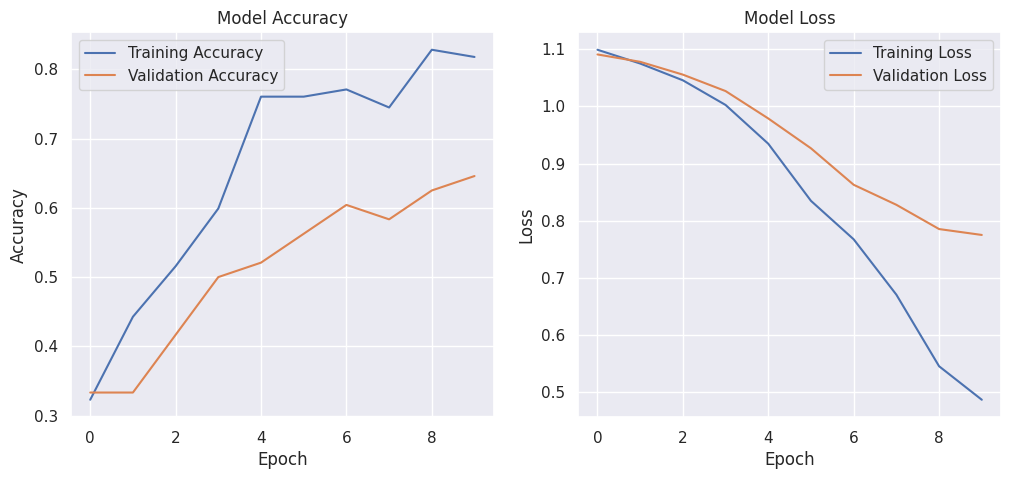

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

This plot shows the model’s accuracy and loss for both training and validation sets over each epoch:

*   **Accuracy Plot** (left): Training accuracy improves steadily, while validation accuracy also increases but remains lower, indicating the model is learning but may slightly overfit the training data.
*   **Loss Plot** (right): Both training and validation loss decrease, showing that the model is reducing errors. However, the validation loss remains consistently higher than the training loss, suggesting some overfitting.


In summary, the model is learning well on the training data, with slight overfitting indicated by the gap between training and validation performance.